# It's a Start

### Imports

In [30]:
import simpy
import itertools
import numpy as np
import matplotlib.pyplot as plt

### Creative liberties

*Insert explanation of arrival rate and closing time.

The café is open for 9 hours, say 6:30 to 15:30, with a rush hour around 08:30. As a baseline the café gets around 4 customers per hour, but during rush hours this jumps to 20.

In [31]:
closing_time = 540 # The café is open for 9 hours.

def arrival_rate(time):
    '''
    Arrival rate in customers per --> minute <--.
    Should peak at around 120 minutes in, that's 08:30.
    '''

    baseline = 0.067    # Circa 4 customers per hour.
    peak = 0.34         # Circa 20 customers per hour.
    rush = 120          # That's 08:30
    rush_length = 60    # Length of rush hour (1 hour).

    return (baseline +   (peak *   (np.exp(-((time-rush)**2) / (2*(rush_length**2))))   )   )

Additionally, there are some variables which should be hard-coded in the system. For example, the chance that a coffee machine needs to be utilized in order to complete an order could be something like 90%. In the same vein, the likelihood that an oven needs to be used to complete an order (to heat up a cinnamon bun, or something like that) could be 15%.

Notably, we're normalizing everything to SimPy time units = minutes. For the sake of avoiding confusion and ensuring consistency, we will wisely also define seconds, minutes and hours in this context.

* Note that every function that returns a duration should return said value in *minutes*.

These are global variables.

In [32]:
SECONDS = 1/60
MINUTES = 1
HOURS = 60

CHANCE_THAT_COFFEE_MACHINE_NEEDED = 0.9
CHANCE_THAT_OVEN_NEEDED = 0.15

### Metrics that I'm going to keep track of: a checklist.

1) How long customers have to wait, from when they arrive at the café to when they pick up their order.
    - Would also be nice to see how long customers wait in each "act" (waiting to order + ordering, waiting for their order, picking up their order).  
2) How well all resources are utilized (employees in particular), how much idle time they have.

In [33]:
class Stats:
    def __init__(self):
        # CUSTOMER TIME-TRACKING
        self.register_queue_time = []           # Time each customer spent waiting to place their order.
        self.pickup_queue_time = []             # Time each custimer spent picking up their order.
        self.total_time_in_system = []          # Total time each customer spent from arrival time to pickup time.
        
        self.time_until_prep_begins = []        # The time from the customer places the order until a barista begins working on it.

        self.arrival_times = []                 # For plotting.

        # OTHER CUSTOMER-RELATED MEASURES
        self.avg_length_register_queue = []     # This is a list because we might also want to graph this. Average length of queue per every hour, or something.
        self.avg_length_pickup_queue = []       # I don't think this has ever not been 0. I'm tracking it for the sake of consistency, though.
        self.avg_count_customers_waiting = []   # Could also be cool to graph.

        # TODO: RESOURCE UTILIZATION


### Time distributions defined

*Needs revision

Note that these should all return the time in minutes.

In [34]:
# Once again, we have yet to pin down the service time distribution,
# but to start implementing I'll just assume that it takes at least 5 seconds
# and that the mean is 45 seconds with a standard deviation of 10. Or something.
def order_time(rng):
    '''How long it takes a customer to order, in minutes.'''
    return max(5, rng.normal(45, 10)) * SECONDS


# ... it's gotta take at least 5 seconds, that's if you're just taking out a croissant and putting it on a dish or something.
# I'll just take a wild guess of 3 minutes (180 seconds) as the mean and 20 seconds as the standard deviation.
# Also I added the time it takes to pay. 
def making_order_time(rng):
    '''How long it takes to get the order ready.
    TODO: We might want to change this process later, add coffe machines and such as resources, and so on.
    For now though, it's just a distribution like so.'''

    #       Time taken to order             Time taken to pay
    return (max(10, rng.normal(180, 20)) + max(3, rng.normal(7, 3))) * SECONDS


# It's gotta take at least a second.
# I'm just going to be optimistic and guess that the mean is 5 seconds, and the std is 1.
def pickup_time(rng):
    '''How long it takes the customer to pick up the order.'''
    return max(1, rng.normal(5, 1)) * SECONDS


# Uniform distribution, minimum 0.5 minutes and maximum 2 minutes.
def coffee_machine_time(rng):
    '''How long it takes the barista to use the coffee machine for a given order.'''
    return rng.uniform(low=30, high=120) * SECONDS


# Uniform distribution, minimum 1 minute maximum 5 minutes (just to heat things up).
def oven_time(rng):
    '''How long it takes the barista to use the oven for a given order.'''
    return rng.uniform(low=60, high=300) * SECONDS

In [35]:
def use_coffee_machine(env, ID, coffee_machine, rng):
    with (coffee_machine.request() as req):
        yield req
        time = coffee_machine_time(rng)
        print(f"{ID} using coffee machine for {time:.2f} seconds at {env.now:.2f}.")
        yield env.timeout(time)

def use_oven(env, ID, oven, rng):
    with (oven.request() as req):
        yield req
        time = oven_time(rng)
        print(f"{ID} using oven for {time:.2f} seconds at {env.now:.2f}.")
        yield env.timeout(time)

### Meatier functions

In [36]:

def customer(env, stats_keeper, ID, register, barista, pickup, coffee_machine, oven, rng):
    '''Customer's "lifecycle".
    They arrive, wait in line, order + pay, wait for their order, and then pick up their order.
    
    Params:
        - env:              simpy.Environment.
        - ID:               int, customer's ID.
        - register:     
        - barista:
        - pickup:
        - coffee_machine:
        - oven:             
        - rng:              RNG.

    Returns:
        - everlasting happiness

    '''

    arrival = env.now
    print(f'{ID} arrives at {arrival:.2f}')

    # TODO: I could refactor these "acts" into different function. For readibility. 

    # # # # # # # # # # # # # # 
    #   ACT I: The Register   #
    # # # # # # # # # # # # # # 
    with (register.request() as req):
        yield req # Waiting in line.

        start_ordering = env.now

        print(f"{ID} begins ordering at {start_ordering:.2f}")

        # We wait while the customer places their order.
        ordering = order_time(rng)
        yield env.timeout(ordering)

        stop_ordering = env.now
        print(f"{ID} finishes ordering at {stop_ordering:.2f}")

    # # # # # # # # # # # # # # 
    #   ACT II: The Waiting   #
    # # # # # # # # # # # # # # 
    # The barista may need to #
    # use the coffee machine  #
    # and/or oven to complete #
    # the order, and on top   #
    # of that some time gets  #
    # added.                  #
    # # # # # # # # # # # # # # 
    with (barista.request() as req):
        yield req

        prep_begin = env.now
        print(f"{ID}'s order preperation begins at {prep_begin:.2f}")

        # The time it takes to get an order ready is:
        #
        #       time using coffee machine   Distribution: Uniform
        #   +   time using oven             Distribution: Uniform
        #   +   general prep time           Distribution: Triangle
        #   =   total time                  Distribution: Looks a bit sillier

        needs_coffee =  rng.random() < CHANCE_THAT_COFFEE_MACHINE_NEEDED
        needs_oven =    rng.random() < CHANCE_THAT_OVEN_NEEDED
        if (needs_coffee):
            use_coffee_machine(env, ID, coffee_machine, rng)
        if (needs_oven):
            use_oven(env, ID, oven, rng)

        prep_time = making_order_time(rng)
        yield env.timeout(prep_time)

        # - - - - - - - - - - Order finished! - - - - - - - - - -

        time_ready = env.now
        print(f"{ID}'s is ready for pickup at {time_ready:.2f}")


    # # # # # # # # # # # # # # 
    #   ACT III: The Pickup   #
    # # # # # # # # # # # # # #
    with pickup.request() as req:
        yield req

        start_pickup = env.now
        print(f"{ID} goes to pick up their order at {start_pickup:.2f}")

        pickupp_time = pickup_time(rng)
        yield env.timeout(pickupp_time)

        end_time = env.now
        print(f"{ID} leaves at {end_time:.2f}")

    # # # # # # # # # # # # # # #
    #   ALSO: Gathering Stats   #
    # # # # # # # # # # # # # # #

    time_in_register_queue = (start_ordering - arrival)
    time_in_pickup_queue = (time_ready - start_pickup)
    total_time = end_time - arrival
    stats_keeper.register_queue_time.append(time_in_register_queue)  # TODO: Do we maybe want :.2f?
    stats_keeper.pickup_queue_time.append(time_in_pickup_queue)
    stats_keeper.total_time_in_system.append(total_time)

    time_from_order_to_prep_start = time_ready - prep_begin
    stats_keeper.time_until_prep_begins.append(time_from_order_to_prep_start)


In [37]:

def arrivals_generator(env, stats_keeper, register, barista, pickup, coffee_machine, oven, arrival_rate, closing_time, seed=None):
    '''
    Generates customer arrival times using a
        PIECEWISE-CONSTANT NON-HOMOGENEOUS POISSON PROCESS.

    Params:
        - env:      simpy.Environment.
        - rates:    a dictionary, the keys being time passed (breakpoints) in minutes 
                    and the values being arrival rates.
        - seed:     int, seed for RNG.

    Returns:
        - Arrivals. Floats.
    '''

    rng = np.random.default_rng(seed)

    customer_ID = 0
    inter_arrival = 0
    while True:

        if ((env.now + inter_arrival) >= closing_time):
            print(f"\nCLOSING SHOP. \nNo more arrivals after closing at {closing_time:.2f}.\n")
            return

        rate = arrival_rate(env.now)

        inter_arrival = rng.exponential(1 / rate)       # Inter arrival from exponential dist.
        yield env.timeout(inter_arrival)                # Waiting until the next arrival.

        arrival_time = env.now                          # For plotting.
        stats_keeper.arrival_times.append(arrival_time)

        env.process(customer(
            env, 
            stats_keeper,
            customer_ID, 
            register, 
            barista,
            pickup,
            coffee_machine,
            oven,
            rng
        ))
        customer_ID += 1

I should probably add a short description above each function. Readibility reasons.

In [38]:
def simulate(num_registers, num_baristas, num_pickups, num_coffee_machines, num_ovens, arrival_rate, closing_time, ttl):
    '''
    Simulates the process with the specified:
        - num_registers:    int, number of registers / staff at registers.
        - num_baristas:     int, number of baristas (those preparing orders).
        - num_pickups:      int, number of places where drinks can be picked up.
        - rates:            dict, the customers-per-hour rate for each period of time.
        - closing_time:     int, this is when new customers should stop coming in. This is just when we stop taking orders.
        - ttl:              number, "time-to-live", how long the simulation will be allowed to run (in case there are some customers still awaiting their orders).

    Returns:
        - statistics:       Stats class object. Just stats for this particular run.
    '''
    
    env = simpy.Environment()
    statistics = Stats()

    register = simpy.Resource(env, capacity=num_registers)      # Note: SimPy resources are FIFO by default.
    barista = simpy.Resource(env, capacity=num_baristas)        # We have [CAPACITY] amount of baristas, each can focus on one order at a time.
    pickup = simpy.Resource(env, capacity=num_pickups)

    # TODO: Adding coffee machines and oven
    coffee_machine = simpy.Resource(env, capacity=num_coffee_machines)
    oven = simpy.Resource(env, capacity=num_ovens)

    env.process(arrivals_generator(
        env=env, 
        stats_keeper=statistics,
        register=register, 
        barista=barista,
        pickup=pickup,
        coffee_machine=coffee_machine,
        oven=oven,
        arrival_rate=arrival_rate,
        closing_time=closing_time,
        seed=360
    ))
    env.run(until=ttl)  # TODO: NOTE: way beyond closing time. I just wanted to see how much would be done in this time. People stop coming in after closing.

    return statistics


In [39]:
def print_stats(statistics):
    print("Total times in register queue:\n", statistics.register_queue_time)
    print("Time from when the order is placed until a barista begins working on it:\n", statistics.time_until_prep_begins)
    print("Total times in pickup queue:\n", statistics.pickup_queue_time)
    print("Total times in system:\n", statistics.total_time_in_system)
    # We'll want to add more.

In [40]:
def plot_stats(statistics):
    plt.plot(statistics.total_time_in_system)
    plt.ylabel('Waiting time for customers 0 to i')
    plt.show()
    
    plt.plot(statistics.register_queue_time)
    plt.ylabel('Waiting time in register queue for customers 0 to i')
    plt.show()
    
    plt.plot(statistics.pickup_queue_time)
    plt.ylabel('Waiting time in pickup queue for customers 0 to i')
    plt.show()
    
    plt.plot(statistics.time_until_prep_begins)
    plt.ylabel('Waiting time until barista begins working on order for customers 0 to i')
    plt.show()

In [41]:
def plot_arrivals(statistics):
    '''
    Plots arrivals as a scatter plot + rate histogram.
    '''
    arrivals = statistics.arrival_times
    
    plt.figure(figsize=(10,4))

    # Scatter plot
    plt.scatter(arrivals, [0]*len(arrivals), s=10)
    plt.title("Customer Arrival Times")
    plt.xlabel("Time (minutes)")
    plt.yticks([])
    plt.show()

    # Histogram
    plt.figure(figsize=(10,4))
    plt.hist(arrivals, bins=30)
    plt.xlabel("Time (minutes)")
    plt.ylabel("# Arrivals")
    plt.title("Histogram of Arrivals")
    plt.show()


## Default run, default values

We start out with:
| Number | Resource | Explanation |
| ------ | -------- | ----------- |
| 1 | Register | Order-takers. |
| 2 | Barista | Order-preparers. |
| 1 | Pickup station | Where customers pick up their orders. |
| 2 | Coffee Machine | The baristas take turn using the coffee machines. |
| 1 | Oven | The baristas take turns using the ovens. |

In [42]:
default = simulate(1, 2, 1, 2, 1, arrival_rate, closing_time, 1000)

0 arrives at 4.28
0 begins ordering at 4.28
0 finishes ordering at 4.97
0's order preperation begins at 4.97
0's is ready for pickup at 8.05
0 goes to pick up their order at 8.05
0 leaves at 8.13
1 arrives at 15.08
1 begins ordering at 15.08
1 finishes ordering at 15.86
1's order preperation begins at 15.86
1's is ready for pickup at 18.87
1 goes to pick up their order at 18.87
1 leaves at 18.96
2 arrives at 21.54
2 begins ordering at 21.54
3 arrives at 21.78
2 finishes ordering at 22.11
2's order preperation begins at 22.11
3 begins ordering at 22.11
3 finishes ordering at 22.57
3's order preperation begins at 22.57
2's is ready for pickup at 24.48
2 goes to pick up their order at 24.48
2 leaves at 24.56
3's is ready for pickup at 25.26
3 goes to pick up their order at 25.26
3 leaves at 25.30
4 arrives at 28.58
4 begins ordering at 28.58
4 finishes ordering at 29.26
4's order preperation begins at 29.26
4's is ready for pickup at 32.43
4 goes to pick up their order at 32.43
4 leaves a

#### Stats Display

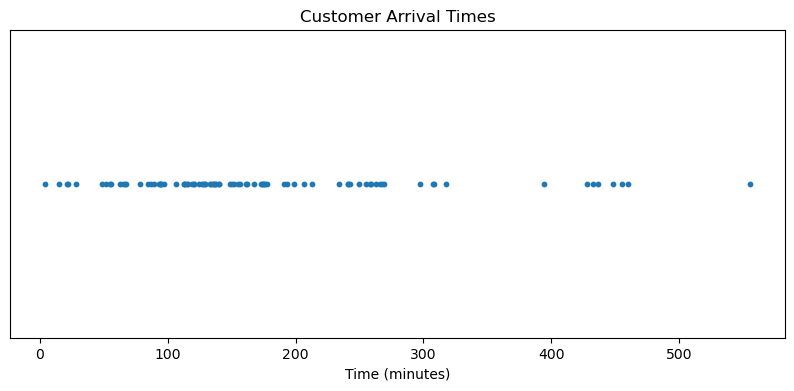

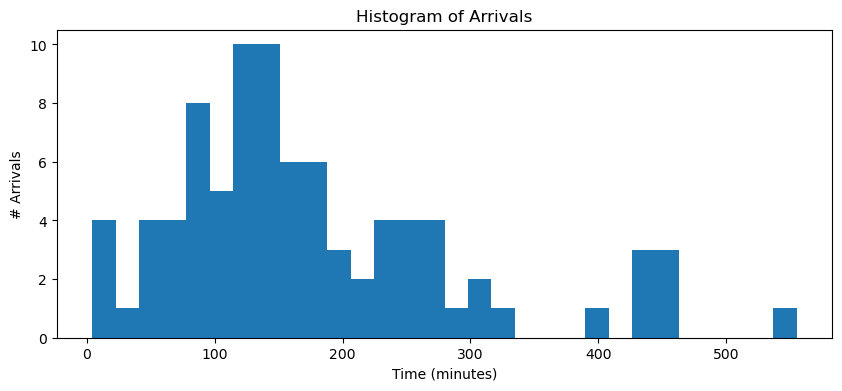

Total times in register queue:
 [0.0, 0.0, 0.0, 0.33072524590918917, 0.0, 0.0, 0.0, 0.0, 0.6607807675583786, 0.0, 0.0, 0.0, 0.0011132070698920415, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8403506344762945, 1.198567028654594, 0.0, 0.0, 0.0, 0.5242322756474636, 0.6096334580126097, 0.0, 0.0, 0.0, 0.0, 0.4120209238920296, 0.0, 0.0, 0.0, 0.0, 0.5589805483109842, 0.0, 0.0, 0.0, 0.0, 0.4511651445169491, 0.33006181396680745, 0.0, 0.3728673489787866, 0.0, 0.0, 0.14083566884860943, 0.0, 0.0, 0.0, 0.13155445833197632, 0.0, 0.5489802018254295, 0.0, 0.2202284060139732, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.43780999027288203, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.630271601703214, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Time from when the order is placed until a barista begins working on it:
 [3.0813241257273543, 3.0067663774764775, 2.3738932534057398, 2.6880437953099694, 3.1728338742414053, 3.073567199843545, 3.3152862048560223, 3.289334582605335, 2.435880173480463, 2.53

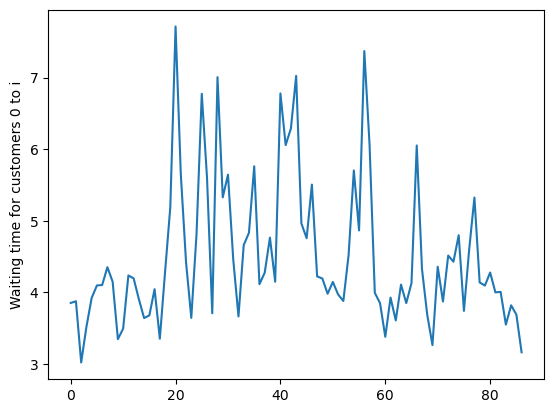

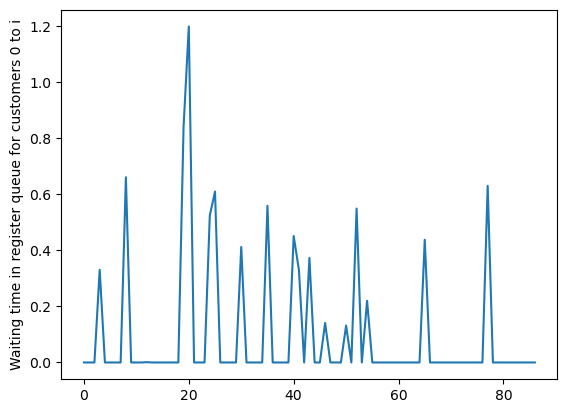

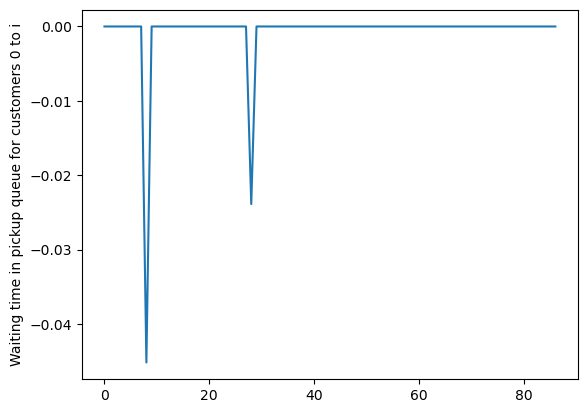

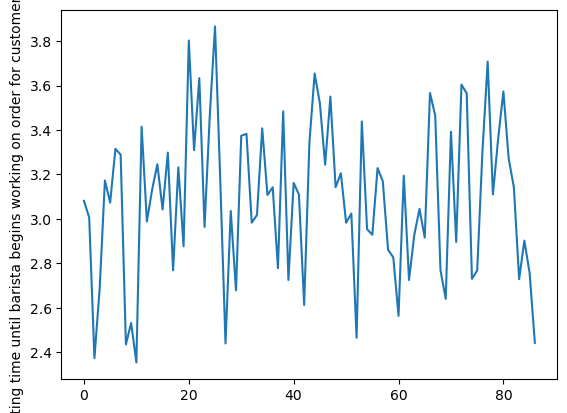

In [43]:
plot_arrivals(default)
print_stats(default)
plot_stats(default)

*Insert thoughtful discussion of results.

# Experiment #1: Add one more register.

In [44]:
exp_1 = simulate(2, 2, 1, 2, 1, arrival_rate, closing_time, 1000)

0 arrives at 4.28
0 begins ordering at 4.28
0 finishes ordering at 4.97
0's order preperation begins at 4.97
0's is ready for pickup at 8.05
0 goes to pick up their order at 8.05
0 leaves at 8.13
1 arrives at 15.08
1 begins ordering at 15.08
1 finishes ordering at 15.86
1's order preperation begins at 15.86
1's is ready for pickup at 18.87
1 goes to pick up their order at 18.87
1 leaves at 18.96
2 arrives at 21.54
2 begins ordering at 21.54
3 arrives at 21.78
3 begins ordering at 21.78
2 finishes ordering at 22.11
2's order preperation begins at 22.11
3 finishes ordering at 22.37
3's order preperation begins at 22.37
2's is ready for pickup at 24.40
2 goes to pick up their order at 24.40
2 leaves at 24.48
3's is ready for pickup at 25.06
3 goes to pick up their order at 25.06
3 leaves at 25.10
4 arrives at 28.58
4 begins ordering at 28.58
4 finishes ordering at 29.26
4's order preperation begins at 29.26
4's is ready for pickup at 32.43
4 goes to pick up their order at 32.43
4 leaves a

#### Stats display

Total times in register queue:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.38337439130550877, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29942777066881376, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.054557818772508426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Time from when the order is placed until a barista begins working on it:
 [3.0813241257273543, 3.0067663774764775, 2.2877084064072655, 2.6880437953099694, 3.1728338742414053, 3.073567199843545, 3.3152862048560223, 2.435880173480463, 2.9122685812129063, 2.5322359925811213, 2.354579181879572, 2.7736448270386944, 2.9887177450508062, 3.13128317574548, 3.245892260916662, 3.042483602746401, 3.298507777268, 2.7688654510114787, 3.7597058500636678,

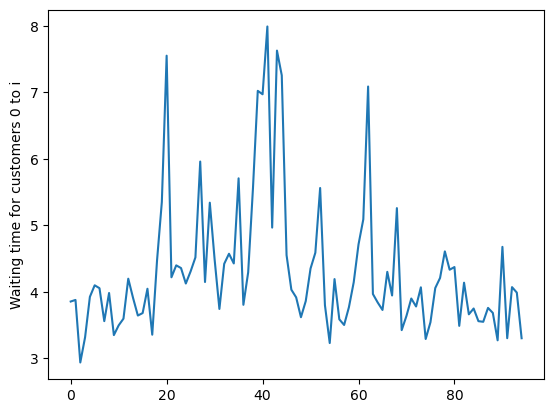

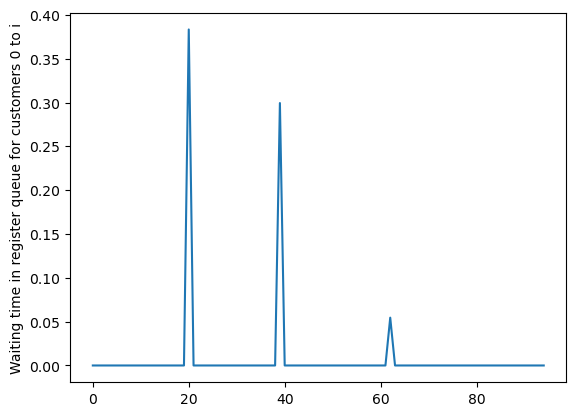

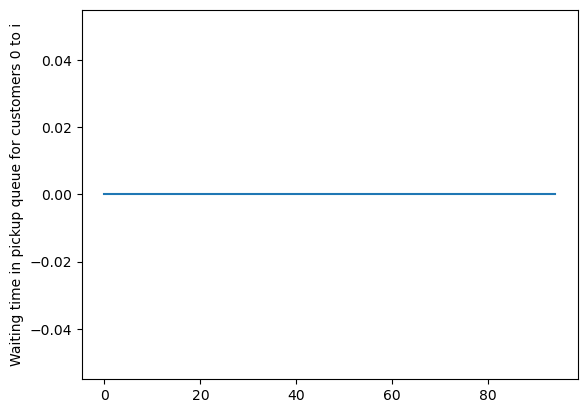

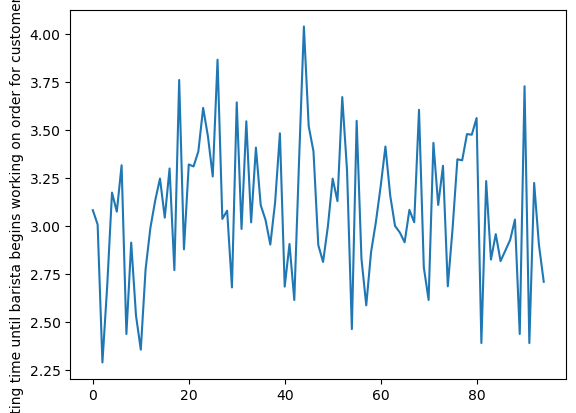

In [45]:
print_stats(exp_1)
plot_stats(exp_1)

... well something went wrong here. A negative number of waiting? How?
Adding a register also doesn't really seem to be making things significantly better.

# Experiment #2: Impossible numbers.

In [46]:
exp_2 = simulate(100, 100, 100, 100, 100, arrival_rate, closing_time, 1000)

0 arrives at 4.28
0 begins ordering at 4.28
0 finishes ordering at 4.97
0's order preperation begins at 4.97
0's is ready for pickup at 8.05
0 goes to pick up their order at 8.05
0 leaves at 8.13
1 arrives at 15.08
1 begins ordering at 15.08
1 finishes ordering at 15.86
1's order preperation begins at 15.86
1's is ready for pickup at 18.87
1 goes to pick up their order at 18.87
1 leaves at 18.96
2 arrives at 21.54
2 begins ordering at 21.54
3 arrives at 21.78
3 begins ordering at 21.78
2 finishes ordering at 22.11
2's order preperation begins at 22.11
3 finishes ordering at 22.37
3's order preperation begins at 22.37
2's is ready for pickup at 24.40
2 goes to pick up their order at 24.40
2 leaves at 24.48
3's is ready for pickup at 25.06
3 goes to pick up their order at 25.06
3 leaves at 25.10
4 arrives at 28.58
4 begins ordering at 28.58
4 finishes ordering at 29.26
4's order preperation begins at 29.26
4's is ready for pickup at 32.43
4 goes to pick up their order at 32.43
4 leaves a

Total times in register queue:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Time from when the order is placed until a barista begins working on it:
 [3.0813241257273543, 3.0067663774764775, 2.2877084064072655, 2.6880437953099694, 3.1728338742414053, 3.073567199843545, 3.3152862048560223, 2.435880173480463, 2.9122685812129063, 2.5322359925811213, 2.354579181879572, 2.7736448270386944, 3.4333820220652456, 3.13128317574548, 3.245892260916662, 3.042483602746401, 3.298507777268, 2.7688654510114787, 2.5191540455813026, 2.8001664865248017, 3.043879139293537, 2.948496627265115, 3.38773869

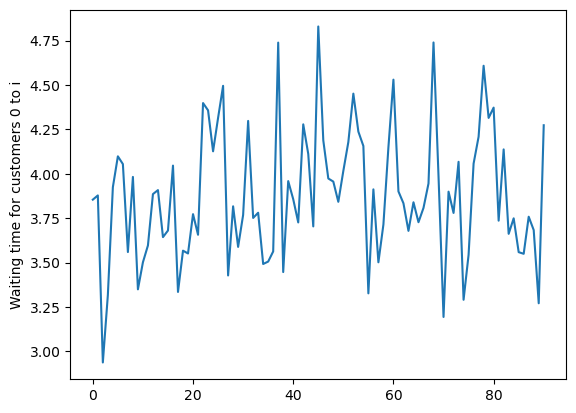

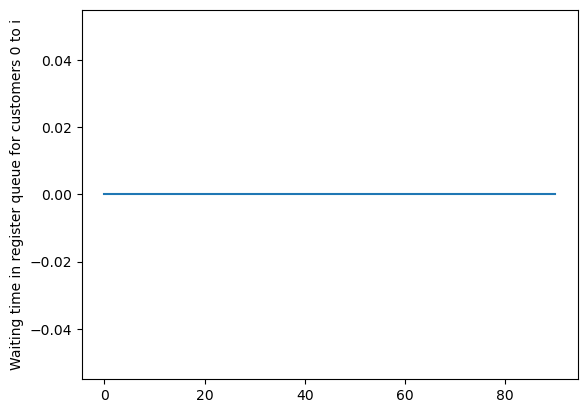

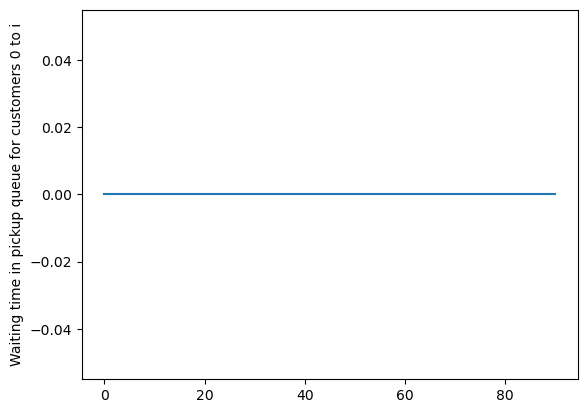

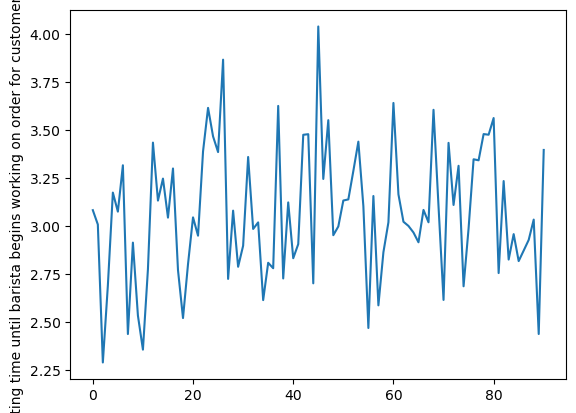

In [47]:
print_stats(exp_2)
plot_stats(exp_2)

Some analysis could probably be done here. But not today.

# TODOS:

*See Google Doc